In [1]:
import pandas as pd
import clips


In [2]:
baseds = pd.read_csv('./data/Amazon_popular_books_dataset.csv')
baseds.shape


(2269, 40)

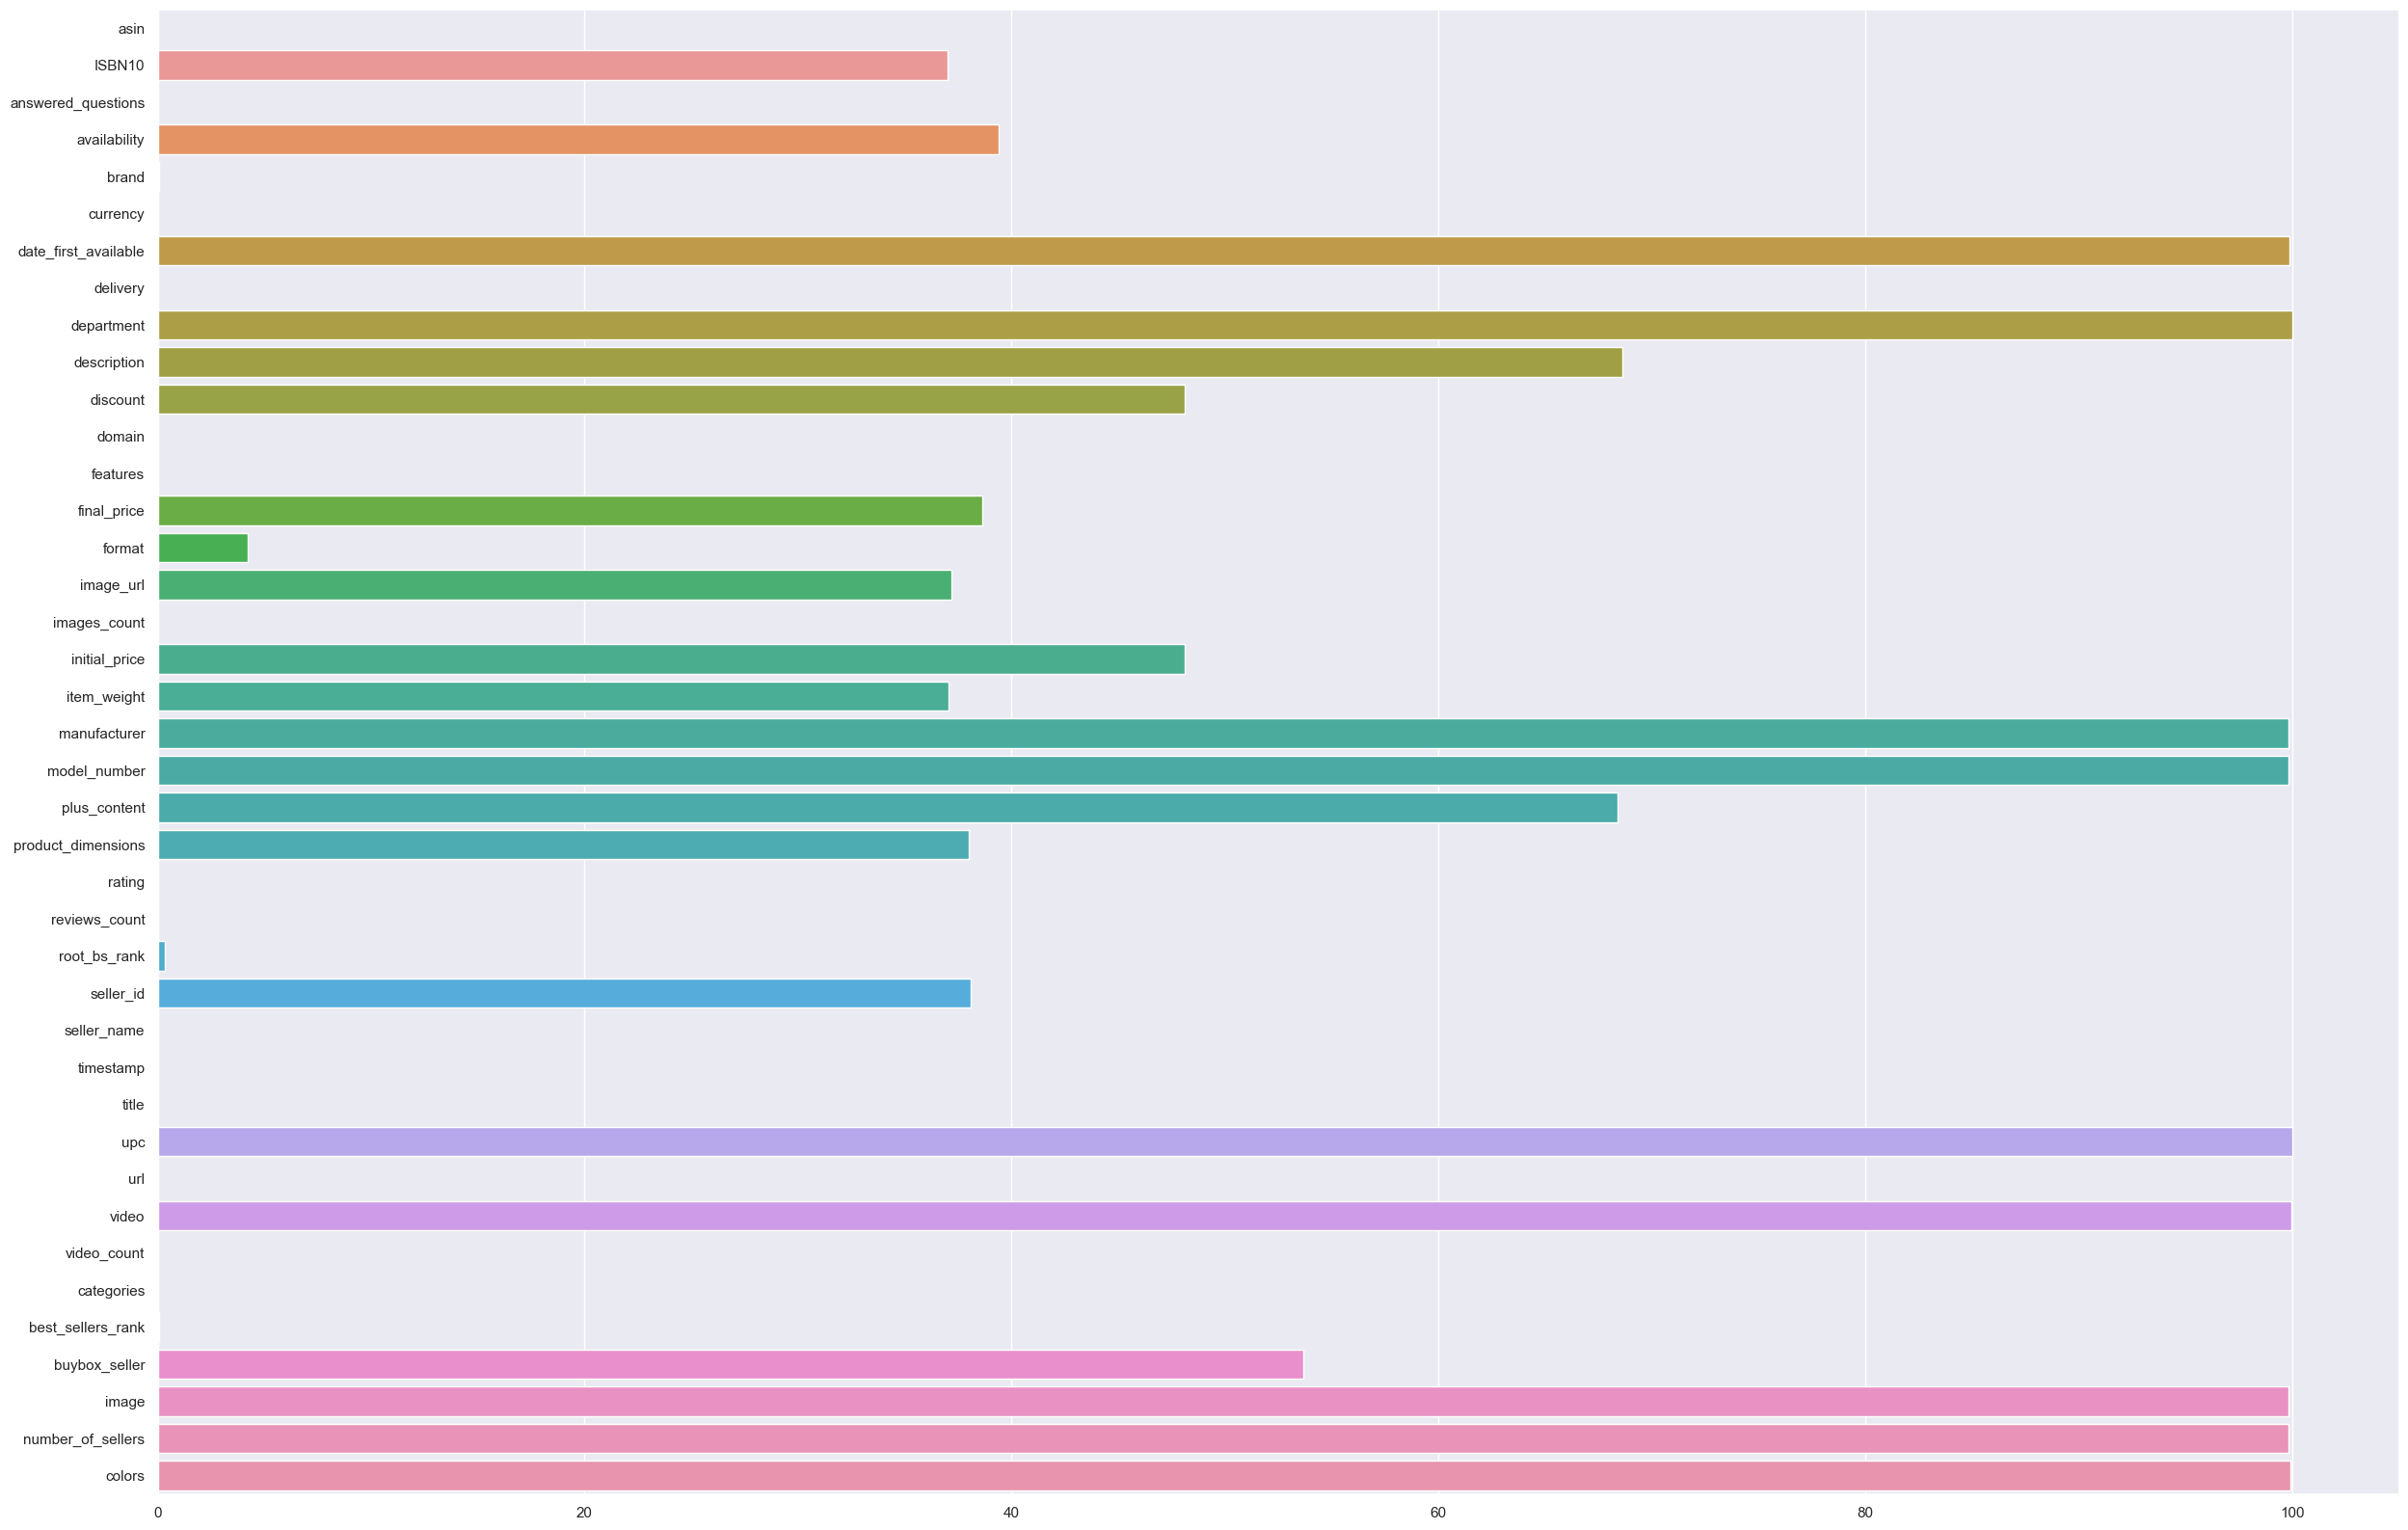

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

#this requires to run pip install missingno
#import missingno
#it does give an overall very good idea about the situation of the fields. 
#missingno.matrix(baseds, figsize = (30,10))

#alternativly this can be constructed manually, but not rapresneted as good in terms of where the distribution of data is. 

dataset_stats = dict()
#the inverse of the row count, to compute the % na 
r = 1 / baseds.shape[0]

#go through each column, and get the % of fields that are na. since this is (0-1) mutiply by 100 to make it more human
for column in baseds.columns:
    dataset_stats[column] = r * baseds[column].isna().sum() * 100

#some basic settings to make the plot visible. 
fig, ax = plt.subplots(figsize=(30, 20))
sns.set(font_scale=1)

#sns doesn't like array seems to prefer lists.
sns.barplot(y=list(dataset_stats.keys()), x=list(dataset_stats.values()), orient = "h")

del ax, column, dataset_stats, fig, r

In [3]:
#drop the columns we don't need, since there are quite a few, 
#this is split on multiple lines to make it more readable. 
baseds.drop(['answered_questions','currency','date_first_available', 'department', 'domain','features'], inplace=True, axis=1)
baseds.drop(['manufacturer','model_number','plus_content','product_dimensions', 'upc', 'video','video_count'], inplace=True, axis=1)
baseds.drop(['buybox_seller','image','number_of_sellers','colors', 'description', 'delivery'], inplace=True, axis=1)

In [4]:
#as well we want only to recomend books that are in stock. Drop rows for books that are not marked in stock. 
#should this have been a real time system, a filter is a better choice. 

rowindex = baseds[baseds['availability'] != 'In Stock.'].index
baseds.drop(rowindex, axis=0, inplace=True)

#one of the rows has this cell empty. 
baseds.dropna(subset=['best_sellers_rank'], inplace=True)
 
#cleanup the memory
del rowindex 

baseds.shape

(1249, 21)

In [5]:

#intialize the clips enviorment. 
environment = clips.Environment()

#this makes the kernel crash less after reload. 
environment.reset();

#load our classes. 
environment.load('templates.clp')
environment.load('rules.clp')

 

Helper functions to populate clips facts from data. 



In [6]:
import json 
import re  

def get_list_as_clips(items):

    result = ""
    for i in items: 
        result += f' "{cleanstr(i)}"' 

    return result 

def cleanstr(s):
    return re.sub("['\"]", "", s)


#helper function to convert a pandas row to a fact. 
#unforunatly i could not manage to find a more efficient way. 
#there is a way to convert to dictionary and load the dictionary inside clips 
#however this requires to initiaze the fact too, which made it impossible. 
def to_clips_fact(env, r):  

    #parse the json   
    jcategories = json.loads(r["categories"])
    #all categories have books category. 
    if ('Books' in jcategories): jcategories.remove('Books')
    #clean special chars
    jcategories = [cleanstr(item) for item in jcategories]

    jrankcategorie = json.loads(r["best_sellers_rank"])

    #each row rapresents a book, and each book might be in multiple category ranks 
    #this will create a distinct fact per rank.
    for n in jrankcategorie:
        rcat = n['category'].split(' / ') 

        #clean any chars that might break clips. 
        rcat = [cleanstr(item) for item in rcat]

        #again rank category have books in all of them. 
        if ('Books' in rcat): rcat.remove('Books')

        factstr = f'(amazonbook (asin "{r["asin"]}") (ISBN10 "{r["ISBN10"]}") (title "{cleanstr(r["title"])}")  (categories {get_list_as_clips(jcategories)}) (rankcategories {get_list_as_clips(rcat)}) (rank {n["rank"]}) )'
        #print(factstr) #for debugging issues..
        env.assert_string(factstr)
                            
  
for _, row in baseds.iterrows():
    to_clips_fact(environment, row)


del row 

In [7]:
#user input.

books = ["Skincare: The award-winning ultimate no-nonsense guide and Sunday Times No. 1 best-seller",
         "Homo Deus: A Brief History of Tomorrow"]


environment.assert_string(f'(request (id "1") (preferences {get_list_as_clips(books)}))')





TemplateFact: (request (id "1") (preferences "Skincare: The award-winning ultimate no-nonsense guide and Sunday Times No. 1 best-seller" "Homo Deus: A Brief History of Tomorrow"))

In [8]:
 
environment.eval("(watch facts)")
environment.eval("(watch activations)")

#this took me a lot of time to figure out!
environment.eval("(run)")

recommended_books = environment.eval("(find-all-facts ((?rb book_recommendation)) TRUE)")

for rb in recommended_books:
    print(rb['asin'], "by", rb['rankcategories'], rb['requestid'], rb['rank'])
 
#debugging..
#for fact in environment.facts():
#    print(fact)


0062316117 by ('History', 'World', 'Civilization & Culture') 1 2
1982133279 by ('Politics & Social Sciences', 'Social Sciences', 'Ethnic Studies', 'African Descent & Black', 'African American Studies') 1 11
1524763160 by ('History', 'World') 1 14
0553380168 by ('Science & Math', 'Evolution') 1 13
1626250766 by ('Science & Math', 'Behavioral Sciences', 'Cognitive Psychology') 1 87
0062316095 by ('History', 'World', 'Civilization & Culture') 1 9
0345538986 by ('Science & Math', 'Evolution') 1 16
164152166X by ('Health, Fitness & Dieting', 'Womens Health', 'General') 1 1
0008375526 by ('Health, Fitness & Dieting', 'Diseases & Physical Ailments', 'Skin Ailments') 1 9
0008375526 by ('Health, Fitness & Dieting', 'Aging', 'Medical Conditions & Diseases') 1 11
0008375526 by ('Health, Fitness & Dieting', 'Aging', 'Beauty, Grooming & Style') 1 3
0008375526 by ('Health, Fitness & Dieting', 'Beauty, Grooming, & Style') 1 57
